In [1]:
import argparse
import os
import numpy as np
import pickle
from word_holder import build_word_holder
from pycocotools.coco import COCO
from data_loader import *
import torch
from tensorboardX import SummaryWriter
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from TheRealNapster import *
from word_holder import word_holder

In [2]:
def create_transforms(transform_args):
    train_trans = []
    val_trans = []
    
    for t in transform_args:
        if t == 'crop':
            train_trans.append(transforms.RandomCrop(224))
        elif t == 'hflip':
            train_trans.append(transforms.RandomHorizontalFlip)  
    
    train_trans.append(transforms.ToTensor())
    train_trans.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    
    val_trans.append(transforms.ToTensor())
    val_trans.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return transforms.Compose(train_trans), transforms.Compose(val_trans)


def val_split(ids, val_fraction, shuffle_dataset=True, random_seed=13):
    dataset_size = len(ids)
    split = int(np.floor(val_fraction * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(ids)
    return ids[split:], ids[:split]


def unnormalize_batch(image_batch):
    inv_batch = torch.empty(image_batch.size())
    for i, image in enumerate(image_batch):
        inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                             std=[1/0.229, 1/0.224, 1/0.225])
        orig_image = inv_normalize(image)
        inv_batch[i] = orig_image
    return inv_batch
   
    
def get_words(captions, vocab):
    sampled_caption = []
    for cap in captions:
        resampleThis = []
        for word_id in cap:
            word = vocab.idx_to_word[word_id]
            resampleThis.append(word)
            if word == '<end>':
                break
        sampled_caption.append(' '.join(resampleThis))
    return sampled_caption
        
    
def val(epoch, data_loader, encode, decode, crit, vocabulary, summary):
    
    encode = encode.eval()
    encode = encode.to(device)
    decode = decode.to(device)
    
    for i, (image_batch, caption_batch, length_batch) in enumerate(data_loader):
        image_batch = image_batch.to(device)
        caption_batch = caption_batch.to(device)
        target_batch = pack_padded_sequence(caption_batch, length_batch, batch_first=True)[0]
       
        # Run through model
        encoder_features = encode(image_batch)
        output = decode(encoder_features, caption_batch, length_batch)

        # Calculate and store loss
        loss = crit(output, target_batch)
        
        # For the first batch, display how we are doing on four images
        if i == 0:
            
            # Unnormalize the images and display on tensorboard
            un_batch = unnormalize_batch(image_batch[0:4])
            summary.add_images('Epoch [{}/{}] Validation Batch Sample'.format(epoch, args.num_epochs), un_batch, epoch)
            
            # Get captions
            caption_ids = decode.ItsGameTime(encoder_features)
            caption_ids = caption_ids[0:4].cpu().numpy() 
            caption = get_words(caption_ids, vocabulary)
            
            # Display the captions in tensorboard
            summary.add_text('Epoch [{}/{}] Image 1 Predicted Caption'.format(epoch, args.num_epochs), caption[0], epoch)
            summary.add_text('Epoch [{}/{}] Image 2 Predicted Caption'.format(epoch, args.num_epochs), caption[1], epoch)
            summary.add_text('Epoch [{}/{}] Image 3 Predicted Caption'.format(epoch, args.num_epochs), caption[2], epoch)
            summary.add_text('Epoch [{}/{}] Image 4 Predicted Caption'.format(epoch, args.num_epochs), caption[3], epoch)
            break
            
    print('VALIDATION: [{}/{}] Epochs, Loss: {:.4f}, Perplexity: {:5.4f}'.\
                      format(epoch, args.num_epochs, loss.item(), np.exp(loss.item())))
    
    ###summary.add_scalar('BLEU/Validation, score, epoch)
    summary.add_scalar('Loss/Validation', loss.item(), epoch) 
    summary.flush()

        
def main(args, run_id):
    
    # Create SummaryWriter object for tracking using tensorboard
    writer = SummaryWriter('{0}/{1}/{2}'.format(args.tensorboard_path, run_id, args.run_id))
                                                                                                      
    # Load vocab built from build_vocab.py
    with open('data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    print("The length of my vocabulary is: " + str(len(vocab)))
    # Load IDs that will be used for training
    with open('data/train_filtered_ids.pkl', 'rb') as f:
        IDs = pickle.load(f)
    
    # Set-up the transforms to apply to the datasets
    train_transforms, val_transforms = create_transforms(args.transforms.split(','))
    
    # Split into training and validation sets
    train_ids, val_ids = val_split(IDs, args.validation_split)
          
    # Load datasets into dataloader
    train_dataloader = get_loader(root=args.image_path, json=args.annotation_path, 
                                  ids=train_ids, vocab=vocab, transform=train_transforms,
                                  batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
    val_dataloader = get_loader(root=args.image_path, json=args.annotation_path, 
                                  ids=val_ids, vocab=vocab, transform=val_transforms,
                                  batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
    
    # Build models
    encoder = Enigma(args.embed_dim).to(device)
    decoder = Christopher(len(vocab), args.embed_dim, 
                          args.units_per_layer, args.num_layers, 
                          args.unit_type, args.pretrained_embedding).to(device)
    
    # Add loss function and gradient optimizer
    criterion = nn.CrossEntropyLoss()
    parameters = list(decoder.parameters()) + list(encoder.dudeWheresMyCar.parameters()) + list(encoder.bn1.parameters()) 
    optimizer = torch.optim.Adam(parameters, lr=args.learning_rate)
    
    # Baseline validation
    #val(0, val_dataloader, encoder, decoder, criterion, vocab, writer)
    
    # Train loop
    num_batches = len(train_dataloader)
    for epoch in range(1, args.num_epochs+1):
        for i, (image_batch, caption_batch, length_batch) in enumerate(train_dataloader):
            image_batch = image_batch.to(device)
            caption_batch = caption_batch.to(device)
            target_batch = pack_padded_sequence(caption_batch, length_batch, batch_first=True)[0]
            
            # Run through model
            encoder_features = encoder(image_batch)
            output = decoder(encoder_features, caption_batch, length_batch)
            
            # Calculate and store loss
            loss = criterion(output, target_batch)
            
            # Backpropagate
            encoder.zero_grad()
            decoder.zero_grad()
            loss.backward()
            optimizer.step()
                
            # Print log info
            if i % args.log_step == 0:
                print('TRAINING: [{}/{}] Epochs, [{}/{}] Batches, Loss: {:.4f}, Perplexity: {:5.4f}'.\
                      format(epoch, args.num_epochs, i, num_batches, loss.item(), np.exp(loss.item())))
                
            # Save the model at checkpoints
            if i % args.save_step == 0:
                torch.save(encoder.state_dict(), 
                           os.path.join(args.model_path, 
                                   'Enigma_{0}-{1}_lr-{2}_nl-{3}_hls-{4}_es-{5}_bs-{6}_t-{7}_pte-{8}.ckpt'\
                                   .format(epoch, i, args.learning_rate, args.num_layers, args.units_per_layer, 
                                           args.embed_dim, args.batch_size, args.unit_type, args.pretrained_embedding)
                                  )
                          )
                torch.save(decoder.state_dict(), 
                           os.path.join(args.model_path, 
                                   'Christopher_{0}-{1}_lr-{2}_nl-{3}_hls-{4}_es-{5}_bs-{6}_t-{7}_pte-{8}.ckpt'\
                                   .format(epoch, i, args.learning_rate, args.num_layers, args.units_per_layer, 
                                           args.embed_dim, args.batch_size, args.unit_type, args.pretrained_embedding)
                                  )
                          )
                
        writer.add_scalar('Loss/Train', loss.item(), epoch) 
        writer.flush()
        
        ### Probably want a BLEU/BLUE score added in here as well
        #val(epoch, val_dataloader, encoder, decoder, criterion, vocab, writer)
    
    writer.close()
       
 

In [3]:
   
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # File structure arguments
    path_args = parser.add_argument_group('Input/output options:')
    path_args.add_argument('--run_id', type=str, default='test', help='tensorboard subdirectory')
    path_args.add_argument('--tensorboard_path', type=str, default='tensorboard_kk', help='Directory for Tensorboard output')
    path_args.add_argument('--model_path', type=str, default='models', help='Directory for saved model checkpoints')
    path_args.add_argument('--image_path', type=str, default='data/images/train_resized', help='Directory with training images')
    path_args.add_argument('--annotation_path', type=str, default='data/annotations/captions_train2014.json', help='Directory with training annotations')
    
    # Data preprocessing arguments
    preproc_args = parser.add_argument_group('Data preprocessing options:')
    preproc_args.add_argument('--transforms', type=str, default='crop', help='Comma separated list of transforms to include in image preprocessing (crop, hflip are supported)')
    
    # Model structure arguments
    model_args = parser.add_argument_group('Model structure options:')
    model_args.add_argument('--embed_dim', type=int, default=256, help='Dimensions of word embedding to use')
    model_args.add_argument('--num_layers', type=int, default=1, help='Number of hidden layers in model')
    model_args.add_argument('--units_per_layer', type=int, default=512, help='Number of hidden units in each hidden layer')
    model_args.add_argument('--unit_type', type=str, default='lstm', help='Defines unit, either lstm or rnn')
    model_args.add_argument('--pretrained_embedding', type=bool, default=False, help='Boolean flag for pretrained embeddings')
    
    # Training arguments
    training_args = parser.add_argument_group('Training options:')
    training_args.add_argument('--batch_size', type=int, default=128, help='Batch size for mini-batch gradient descent')
    training_args.add_argument('--num_workers', type=int, default=2, help='Number of workers for dataloading')
    training_args.add_argument('--validation_split', type=float, default=0.2, help='Validation split percentage for training')
    training_args.add_argument('--num_epochs', type=int, default=5, help='Number of epochs to train on')
    training_args.add_argument('--learning_rate', type=float, default=0.001, help='Set learning rate for training')
    
    # Logging arguments
    log_args = parser.add_argument_group('Logging options:')
    log_args.add_argument('--log_step', type=int, default=10, help='Number of batches between printing status')
    log_args.add_argument('--save_step', type=int, default=500, help='Number of batches between saving models')
                           
    args = parser.parse_args([])
    
    run_id = 'lr-{0}_nl-{1}_hls-{2}_es-{3}_bs-{4}_t-{5}_pte-{6}'.format(args.learning_rate, args.num_layers,
                                                                        args.units_per_layer, args.embed_dim,
                                                                        args.batch_size, args.unit_type,
                                                                        args.pretrained_embedding)
        
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     main(args, run_id)

### coco dataset with training data to check size of the input

In [4]:
# Load vocab built from build_vocab.py
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
print("The length of my vocabulary is: " + str(len(vocab)))
# Load IDs that will be used for training
with open('data/train_filtered_ids.pkl', 'rb') as f:
    IDs = pickle.load(f)

# Set-up the transforms to apply to the datasets
# train_transforms, val_transforms = create_transforms(args.transforms.split(','))
train_transforms, val_transforms = create_transforms('')

# Split into training and validation sets
train_ids, val_ids = val_split(IDs, args.validation_split)

# Load datasets into dataloader
train_dataloader = get_loader(root=args.image_path, json=args.annotation_path, 
                              ids=train_ids, vocab=vocab, transform= train_transforms, #None,
                              batch_size=1, shuffle=False, num_workers=args.num_workers)
coco = CocoDataset(root=args.image_path,
                       json=args.annotation_path,
                       ids = train_ids,
                       vocab=vocab,
                       transform=None)
    

The length of my vocabulary is: 4927
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


In [5]:
for i, (image_batch, caption_batch, length_batch) in enumerate(train_dataloader):
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


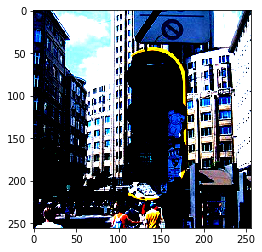

In [6]:
import matplotlib.pyplot as plt
plt.imshow(image_batch.squeeze().cpu().numpy().transpose((1, 2, 0)))

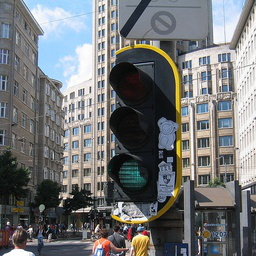

In [7]:
coco[0][0]

In [8]:
for i in range(1000):
    print(coco[i][0].size)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

### coco dataset with test data to check the sizes of the images

In [9]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # File structure arguments
    path_args = parser.add_argument_group('Input/output options:')
    path_args.add_argument('--run_id', type=str, default='test', help='tensorboard subdirectory')
    path_args.add_argument('--tensorboard_path', type=str, default='tensorboard_kk', help='Directory for Tensorboard output')
    path_args.add_argument('--model_path', type=str, default='models', help='Directory for saved model checkpoints')
    path_args.add_argument('--image_path', type=str, default='data/images/test_resized', help='Directory with test images')
    path_args.add_argument('--annotation_path', type=str, default='data/annotations/captions_val2014.json', help='Directory with training annotations')
    
    # Model structure arguments
    model_args = parser.add_argument_group('Model structure options:')
    model_args.add_argument('--embed_dim', type=int, default=256, help='Dimensions of word embedding to use')
    model_args.add_argument('--num_layers', type=int, default=1, help='Number of hidden layers in model')
    model_args.add_argument('--units_per_layer', type=int, default=512, help='Number of hidden units in each hidden layer')
    model_args.add_argument('--unit_type', type=str, default='lstm', help='Defines unit, either lstm or rnn')
    model_args.add_argument('--pretrained_embedding', type=bool, default=False, help='Boolean flag for pretrained embeddings')
    
    # Training arguments
    training_args = parser.add_argument_group('Training options:')
    training_args.add_argument('--batch_size', type=int, default=128, help='Batch size for mini-batch gradient descent')
    training_args.add_argument('--num_workers', type=int, default=2, help='Number of workers for dataloading')
    training_args.add_argument('--validation_split', type=float, default=0.2, help='Validation split percentage for training')
    training_args.add_argument('--num_epochs', type=int, default=5, help='Number of epochs to train on')
    training_args.add_argument('--learning_rate', type=float, default=0.001, help='Set learning rate for training')
    
    # Logging arguments
    log_args = parser.add_argument_group('Logging options:')
    log_args.add_argument('--log_step', type=int, default=10, help='Number of batches between printing status')
    log_args.add_argument('--save_step', type=int, default=250, help='Number of batches between saving models')
                           
    args = parser.parse_args([])
    
    run_id = 'lr-{0}_nl-{1}_hls-{2}_es-{3}_bs-{4}_t-{5}_pte-{6}'.format(args.learning_rate, args.num_layers,
                                                                        args.units_per_layer, args.embed_dim,
                                                                        args.batch_size, args.unit_type,
                                                                        args.pretrained_embedding)
                           
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(args)

Namespace(annotation_path='data/annotations/captions_val2014.json', batch_size=128, embed_dim=256, image_path='data/images/test_resized', learning_rate=0.001, log_step=10, model_path='models', num_epochs=5, num_layers=1, num_workers=2, pretrained_embedding=False, run_id='test', save_step=250, tensorboard_path='tensorboard_kk', unit_type='lstm', units_per_layer=512, validation_split=0.2)


In [10]:
test_transforms = transforms.Compose([
#         transforms.RandomCrop(200),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# Load IDs that will be used for training
with open('data/test_filtered_ids.pkl', 'rb') as f:
    IDs = pickle.load(f)

test_dataloader = get_loader(root=args.image_path, json=args.annotation_path, 
                                  ids=IDs, vocab=vocab, transform=test_transforms,
                                  batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
test_coco = CocoDataset(root=args.image_path,
                       json=args.annotation_path,
                       ids = IDs,
                       vocab=vocab,
                       transform=None)


loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [11]:
for i in range(1000):
    print(test_coco[i][0].size)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

### Coco of the training dataset before resizing:

In [12]:
   
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # File structure arguments
    path_args = parser.add_argument_group('Input/output options:')
    path_args.add_argument('--run_id', type=str, default='test', help='tensorboard subdirectory')
    path_args.add_argument('--tensorboard_path', type=str, default='tensorboard_kk', help='Directory for Tensorboard output')
    path_args.add_argument('--model_path', type=str, default='models', help='Directory for saved model checkpoints')
    path_args.add_argument('--image_path', type=str, default='data/images/train', help='Directory with training images')
    path_args.add_argument('--annotation_path', type=str, default='data/annotations/captions_train2014.json', help='Directory with training annotations')
    
    # Data preprocessing arguments
    preproc_args = parser.add_argument_group('Data preprocessing options:')
    preproc_args.add_argument('--transforms', type=str, default='crop', help='Comma separated list of transforms to include in image preprocessing (crop, hflip are supported)')
    
    # Model structure arguments
    model_args = parser.add_argument_group('Model structure options:')
    model_args.add_argument('--embed_dim', type=int, default=256, help='Dimensions of word embedding to use')
    model_args.add_argument('--num_layers', type=int, default=1, help='Number of hidden layers in model')
    model_args.add_argument('--units_per_layer', type=int, default=512, help='Number of hidden units in each hidden layer')
    model_args.add_argument('--unit_type', type=str, default='lstm', help='Defines unit, either lstm or rnn')
    model_args.add_argument('--pretrained_embedding', type=bool, default=False, help='Boolean flag for pretrained embeddings')
    
    # Training arguments
    training_args = parser.add_argument_group('Training options:')
    training_args.add_argument('--batch_size', type=int, default=128, help='Batch size for mini-batch gradient descent')
    training_args.add_argument('--num_workers', type=int, default=2, help='Number of workers for dataloading')
    training_args.add_argument('--validation_split', type=float, default=0.2, help='Validation split percentage for training')
    training_args.add_argument('--num_epochs', type=int, default=5, help='Number of epochs to train on')
    training_args.add_argument('--learning_rate', type=float, default=0.001, help='Set learning rate for training')
    
    # Logging arguments
    log_args = parser.add_argument_group('Logging options:')
    log_args.add_argument('--log_step', type=int, default=10, help='Number of batches between printing status')
    log_args.add_argument('--save_step', type=int, default=500, help='Number of batches between saving models')
                           
    args = parser.parse_args([])
    
    run_id = 'lr-{0}_nl-{1}_hls-{2}_es-{3}_bs-{4}_t-{5}_pte-{6}'.format(args.learning_rate, args.num_layers,
                                                                        args.units_per_layer, args.embed_dim,
                                                                        args.batch_size, args.unit_type,
                                                                        args.pretrained_embedding)
        
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     main(args, run_id)


# Load vocab built from build_vocab.py
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
print("The length of my vocabulary is: " + str(len(vocab)))
# Load IDs that will be used for training
with open('data/train_filtered_ids.pkl', 'rb') as f:
    IDs = pickle.load(f)

# Set-up the transforms to apply to the datasets
# train_transforms, val_transforms = create_transforms(args.transforms.split(','))
train_transforms, val_transforms = create_transforms('')

# Split into training and validation sets
train_ids, val_ids = val_split(IDs, args.validation_split)

# Load datasets into dataloader
train_dataloader = get_loader(root=args.image_path, json=args.annotation_path, 
                              ids=train_ids, vocab=vocab, transform= train_transforms, #None,
                              batch_size=1, shuffle=False, num_workers=args.num_workers)
coco_unresized = CocoDataset(root=args.image_path,
                       json=args.annotation_path,
                       ids = train_ids,
                       vocab=vocab,
                       transform=None)

The length of my vocabulary is: 4927
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [13]:
for i in range(1000):
    print(coco_unresized[i][0].size)

(640, 480)
(640, 427)
(480, 640)
(480, 640)
(409, 307)
(640, 426)
(500, 334)
(640, 460)
(640, 426)
(640, 480)
(640, 426)
(640, 374)
(640, 344)
(640, 432)
(640, 426)
(640, 427)
(500, 375)
(528, 363)
(600, 400)
(640, 427)
(640, 360)
(640, 480)
(640, 267)
(640, 640)
(640, 480)
(500, 335)
(500, 333)
(640, 427)
(640, 480)
(640, 480)
(640, 480)
(640, 480)
(640, 480)
(640, 480)
(640, 480)
(500, 333)
(640, 480)
(480, 640)
(640, 426)
(612, 612)
(640, 480)
(333, 500)
(315, 315)
(640, 268)
(375, 500)
(640, 332)
(640, 480)
(640, 479)
(640, 425)
(640, 480)
(640, 480)
(640, 359)
(500, 375)
(640, 429)
(640, 480)
(640, 427)
(640, 427)
(333, 500)
(640, 427)
(428, 640)
(640, 427)
(640, 480)
(640, 498)
(480, 640)
(640, 480)
(640, 496)
(480, 640)
(546, 640)
(640, 427)
(612, 612)
(640, 480)
(640, 640)
(427, 640)
(640, 480)
(640, 428)
(640, 435)
(480, 640)
(640, 480)
(426, 640)
(640, 440)
(640, 427)
(335, 500)
(640, 427)
(478, 640)
(640, 427)
(640, 480)
(603, 640)
(480, 640)
(640, 480)
(427, 640)
(640, 480)

(640, 426)
(640, 427)
(640, 424)
(640, 427)
(500, 387)
(640, 426)
(640, 425)
(640, 443)
(612, 612)
(467, 640)
(640, 480)
(640, 426)
(640, 481)
(612, 612)
(640, 480)
(640, 480)
(480, 640)
(333, 500)
(640, 480)
(480, 640)
(500, 375)
(640, 425)
(356, 500)
(612, 612)
(500, 333)
(640, 509)
(640, 428)
(404, 640)
(640, 427)
(640, 480)
(480, 640)
(480, 640)
(640, 426)
(640, 480)
(640, 427)
(429, 640)
(375, 500)
(640, 427)
(428, 640)
(640, 274)
(640, 480)
(640, 428)
(640, 433)
(399, 640)
(640, 480)
(640, 427)
(500, 332)
(640, 480)
(640, 480)
(429, 640)
(640, 425)
(640, 424)
(640, 480)
(640, 635)
(480, 640)
(612, 612)
(640, 268)
(640, 490)
(640, 444)
(640, 480)
(640, 421)
(640, 418)
(640, 426)
(640, 480)
(612, 612)
(612, 612)
(640, 623)
(500, 375)
(640, 480)
(640, 480)
(640, 480)
(640, 478)
(480, 640)
(640, 480)
(640, 427)
(596, 440)
(612, 612)
(640, 480)
(640, 289)
(500, 500)
(612, 612)
(612, 612)
(640, 427)
(640, 427)
(500, 375)
(640, 480)
(375, 500)
(640, 427)
(640, 480)
(500, 375)
(640, 480)

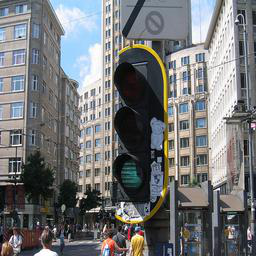

In [14]:
coco[0][0]

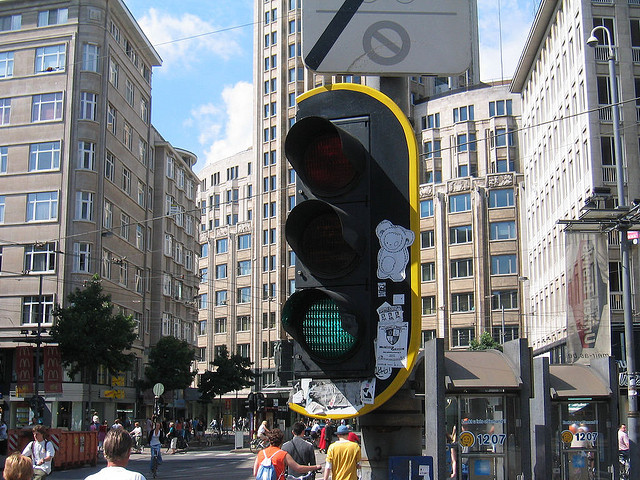

In [15]:
coco_unresized[0][0]